In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate data for sine and cosine waves
def create_wave_data(sequence_length, total_sequences):
    sine_inputs = np.array([np.sin(np.linspace(0, 2 * np.pi, sequence_length)) for _ in range(total_sequences)])
    sine_outputs = np.array([np.sin(np.linspace(0, 2 * np.pi, sequence_length)) for _ in range(total_sequences)])
    cosine_inputs = np.array([np.cos(np.linspace(0, 2 * np.pi, sequence_length)) for _ in range(total_sequences)])
    cosine_outputs = np.array([np.cos(np.linspace(0, 2 * np.pi, sequence_length)) for _ in range(total_sequences)])
    return sine_inputs, sine_outputs, cosine_inputs, cosine_outputs

In [3]:
# Class for RNN Model
class SimpleRNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.hidden_dim = hidden_dim

        # Initialize model weights
        self.Wxh = np.random.randn(hidden_dim, input_dim) * 0.01  # Weight from input to hidden layer
        self.Whh = np.random.randn(hidden_dim, hidden_dim) * 0.01  # Recurrent weight
        self.Why = np.random.randn(output_dim, hidden_dim) * 0.01  # Weight from hidden to output
        self.bh = np.zeros((hidden_dim, 1))  # Bias for hidden layer
        self.by = np.zeros((output_dim, 1))  # Bias for output layer

    def forward_pass(self, inputs):
        previous_h = np.zeros((self.hidden_dim, 1))  # Hidden state initialization
        self.hidden_state_seq = []  # To store hidden states
        predictions = []

        # Process each time step
        for time_step in range(inputs.shape[0]):
            x_input = inputs[time_step].reshape(-1, 1)
            current_h = np.tanh(np.dot(self.Wxh, x_input) + np.dot(self.Whh, previous_h) + self.bh)  # Update hidden state
            output = np.dot(self.Why, current_h) + self.by  # Output calculation

            predictions.append(output)
            self.hidden_state_seq.append(current_h)
            previous_h = current_h

        return np.array(predictions).squeeze()

    def backward_pass(self, inputs, targets, learning_rate=0.001):
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        next_h_grad = np.zeros((self.hidden_dim, 1))  # Gradient initialization for next hidden state

        total_loss = 0
        outputs = self.forward_pass(inputs)

        for t in reversed(range(len(inputs))):
            x_input = inputs[t].reshape(-1, 1)
            predicted_output = outputs[t].reshape(-1, 1)
            true_output = targets[t].reshape(-1, 1)

            # Compute loss (MSE)
            total_loss += (predicted_output - true_output) ** 2

            # Gradients computation
            dy = 2 * (predicted_output - true_output)
            dWhy += np.dot(dy, self.hidden_state_seq[t].T)
            dby += dy

            dh = np.dot(self.Why.T, dy) + next_h_grad
            dh_raw = (1 - self.hidden_state_seq[t] ** 2) * dh  # Backprop through tanh
            dbh += dh_raw
            dWxh += np.dot(dh_raw, x_input.T)

            if t > 0:
                dWhh += np.dot(dh_raw, self.hidden_state_seq[t-1].T)
            next_h_grad = np.dot(self.Whh.T, dh_raw)

        # Update parameters
        for param, dparam in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by],
                                 [dWxh, dWhh, dWhy, dbh, dby]):
            param -= learning_rate * dparam

        return total_loss

In [4]:
# Parameters
sequence_length = 50
total_sequences = 100
num_epochs = 15
learning_rate = 0.001
input_dim = 1
hidden_dim = 16
output_dim = 1

In [6]:
# Generate wave data
sine_inputs, sine_targets, cosine_inputs, cosine_targets = create_wave_data(sequence_length, total_sequences)

In [7]:
# Initialize RNN models
rnn_model_sine = SimpleRNN(input_dim, hidden_dim, output_dim)
rnn_model_cosine = SimpleRNN(input_dim, hidden_dim, output_dim)

In [8]:
# Training loop
for epoch in range(num_epochs):
    total_loss_sine = 0
    total_loss_cosine = 0
    for i in range(total_sequences):
        # Train on sine wave
        input_sine = sine_inputs[i]
        target_sine = sine_targets[i]
        total_loss_sine += rnn_model_sine.backward_pass(input_sine, target_sine, learning_rate)

        # Train on cosine wave
        input_cosine = cosine_inputs[i]
        target_cosine = cosine_targets[i]
        total_loss_cosine += rnn_model_cosine.backward_pass(input_cosine, target_cosine, learning_rate)

    if epoch % 1 == 0:  # Log loss for each epoch
        print(f'Epoch {epoch+1}, Sine Loss: {total_loss_sine.item()/total_sequences:.4f}, Cosine Loss: {total_loss_cosine.item()/total_sequences:.4f}')

Epoch 1, Sine Loss: 15.5126, Cosine Loss: 15.4507
Epoch 2, Sine Loss: 0.0993, Cosine Loss: 0.1733
Epoch 3, Sine Loss: 0.0695, Cosine Loss: 0.0993
Epoch 4, Sine Loss: 0.0515, Cosine Loss: 0.0624
Epoch 5, Sine Loss: 0.0396, Cosine Loss: 0.0414
Epoch 6, Sine Loss: 0.0314, Cosine Loss: 0.0285
Epoch 7, Sine Loss: 0.0254, Cosine Loss: 0.0202
Epoch 8, Sine Loss: 0.0209, Cosine Loss: 0.0147
Epoch 9, Sine Loss: 0.0175, Cosine Loss: 0.0109
Epoch 10, Sine Loss: 0.0148, Cosine Loss: 0.0083
Epoch 11, Sine Loss: 0.0127, Cosine Loss: 0.0065
Epoch 12, Sine Loss: 0.0110, Cosine Loss: 0.0053
Epoch 13, Sine Loss: 0.0096, Cosine Loss: 0.0043
Epoch 14, Sine Loss: 0.0084, Cosine Loss: 0.0037
Epoch 15, Sine Loss: 0.0075, Cosine Loss: 0.0032


In [9]:
# Predict using trained models
predicted_sine_wave = rnn_model_sine.forward_pass(sine_inputs[0])
predicted_cosine_wave = rnn_model_cosine.forward_pass(cosine_inputs[0])

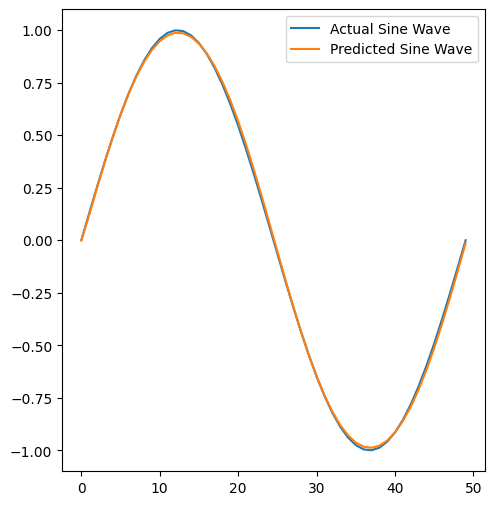

In [10]:
# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sine_inputs[0], label="Actual Sine Wave")
plt.plot(predicted_sine_wave, label="Predicted Sine Wave")
plt.legend()
plt.show()

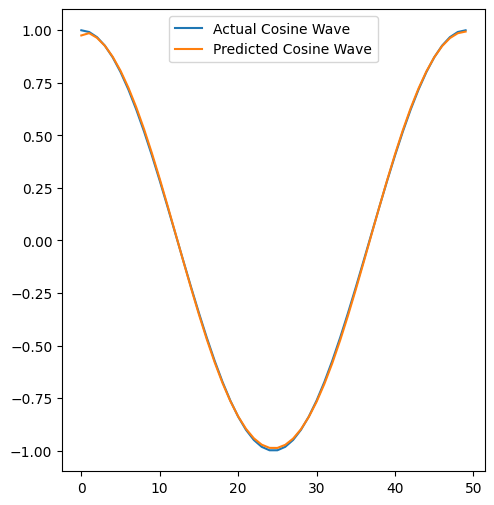

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(cosine_inputs[0], label="Actual Cosine Wave")
plt.plot(predicted_cosine_wave, label="Predicted Cosine Wave")
plt.legend()

plt.show()